# Applied ML : Assignment 2
## Experiment Tracking
## Rohit Roy | MDS202340

### Training and Testing

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, auc, confusion_matrix

Updating from assignment 1, there are 6 functions as follows : 
* `load_splits` - reading the train, test and validation data
* `fit_model` - fitting Naive Bayes model on the training data
* `score_model` - returning the predicted values
* `evaluate_predictions` - returning evaluations by `score_model` function
* `plot_confusion_matrix` - plotting confusion matrix for the 3 models
* `log_experiments` - integrating with mlflow
* `benchmark_models` - testing 3 benchmark models : LogisticRegression, NaiveBayes, RandomForest

In [8]:
def load_splits():
    """
    Load the train, validation, and test splits from CSV files.
    """
    train_df = pd.read_csv('train.csv')
    val_df = pd.read_csv('validation.csv')
    test_df = pd.read_csv('test.csv')
    return train_df, val_df, test_df

def fit_model(train_df):
    """
    Fit a Naive Bayes model on the training data.
    """
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(train_df['message'])
    y_train = train_df['label']
    model = MultinomialNB()
    model.fit(X_train, y_train)
    return model, vectorizer

def score_model(model, vectorizer, df):
    """
    Score the model on the given data.
    """
    X = vectorizer.transform(df['message'])
    y = df['label']
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]  # Probabilities for the positive class
    return y_pred, y_proba

def evaluate_predictions(y_true, y_pred, y_proba):
    """
    Evaluate the model predictions using accuracy, precision, recall, F1 score, and AUCPR.
    """
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    aucpr = auc(recall, precision)
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'aucpr': aucpr
    }
    return metrics

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """
    Plot a confusion matrix using Seaborn.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def log_experiment(model, model_name, vectorizer, train_df, val_df):
    """
    Log the experiment using MLflow.
    """
    with mlflow.start_run(run_name=model_name):
        # Log parameters
        mlflow.log_param("model", model_name)
        
        # Score and evaluate on train data
        y_train_pred, y_train_proba = score_model(model, vectorizer, train_df)
        train_metrics = evaluate_predictions(train_df['label'], y_train_pred, y_train_proba)
        for metric, value in train_metrics.items():
            mlflow.log_metric(f"train_{metric}", value)
        
        # Score and evaluate on validation data
        y_val_pred, y_val_proba = score_model(model, vectorizer, val_df)
        val_metrics = evaluate_predictions(val_df['label'], y_val_pred, y_val_proba)
        for metric, value in val_metrics.items():
            mlflow.log_metric(f"val_{metric}", value)
        
        # Log the model
        mlflow.sklearn.log_model(model, model_name)
        
        return val_metrics['aucpr'], y_val_pred, val_metrics['accuracy']

def benchmark_models(train_df, val_df):
    """
    Build, track, and register 3 benchmark models using MLflow.
    Print confusion matrix and accuracy for each model.
    """
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(train_df['message'])
    y_train = train_df['label']
    
    models = {
        'Naive Bayes': MultinomialNB(),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier()
    }
    
    best_model_name = None
    best_aucpr = 0
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        aucpr, y_val_pred, accuracy = log_experiment(model, name, vectorizer, train_df, val_df)
        print(f"{name} - Validation AUCPR: {aucpr}")
        print(f"{name} - Validation Accuracy: {accuracy}")
        
        # Plot confusion matrix
        plot_confusion_matrix(val_df['label'], y_val_pred, title=f"{name} Confusion Matrix")
        
        if aucpr > best_aucpr:
            best_aucpr = aucpr
            best_model_name = name
    
    print(f"\nBest Model: {best_model_name} with AUCPR: {best_aucpr}")
    return best_model_name

In [ ]:
# Bash code executed in terminal
!mlflow ui

2025/02/26 19:35:38 INFO mlflow.tracking.fluent: Experiment with name 'Assignment 2' does not exist. Creating a new experiment.
2025/02/26 19:35:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Naive Bayes at: http://127.0.0.1:5000/#/experiments/118700678939842473/runs/aeeefae2cdd44bcbacf80a5a0ceae643
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/118700678939842473
Naive Bayes - Validation AUCPR: 0.9657007358877836
Naive Bayes - Validation Accuracy: 0.9880382775119617


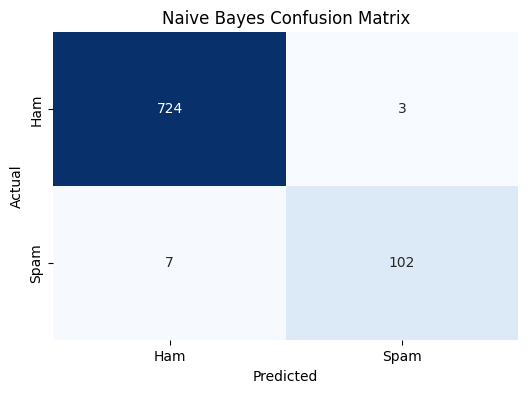

2025/02/26 19:35:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Logistic Regression at: http://127.0.0.1:5000/#/experiments/118700678939842473/runs/0370b2bdae834392b327603c9b5826a7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/118700678939842473
Logistic Regression - Validation AUCPR: 0.9802966007071015
Logistic Regression - Validation Accuracy: 0.9892344497607656


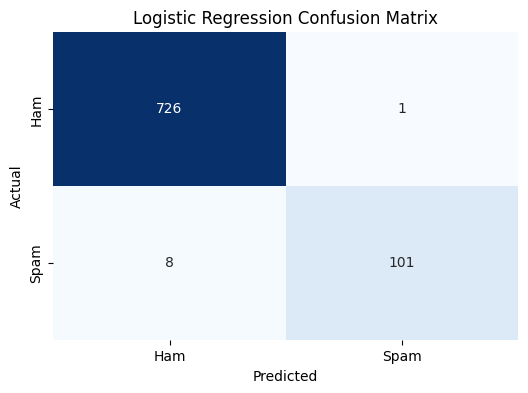

2025/02/26 19:35:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: http://127.0.0.1:5000/#/experiments/118700678939842473/runs/0749f1d3c7c948cbbb7e41cdfbbc74c6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/118700678939842473
Random Forest - Validation AUCPR: 0.9933403780558842
Random Forest - Validation Accuracy: 0.9808612440191388


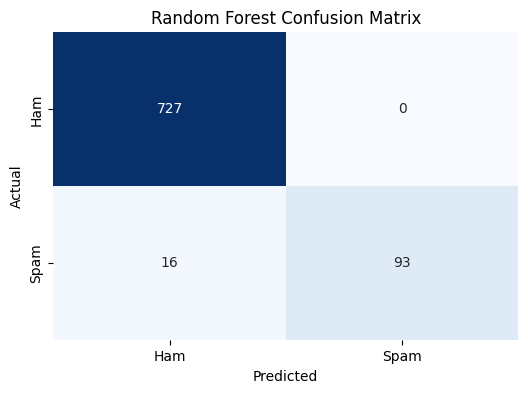


Best Model: Random Forest with AUCPR: 0.9933403780558842


In [11]:
# Load data splits
train_df, val_df, test_df = load_splits()

# Set MLflow tracking URI
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Assignment 2")

# Benchmark models
best_model_name = benchmark_models(train_df, val_df)

Best Model According to AUCPR score is Random Forest.